In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Dropout, Layer, Activation, Reshape, Permute
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.convolutional import Cropping2D
from keras.layers.normalization import BatchNormalization

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
import h5py
import random

#import keras.models as models
#from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
#from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
#from keras.layers.normalization import BatchNormalization
#from keras.callbacks import ModelCheckpoint

import cv2
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
import h5py
import random

from distutils.version import LooseVersion

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

Using TensorFlow backend.


TensorFlow Version: 1.1.0


In [2]:
from tqdm import tqdm
from os.path import isfile, isdir
from urllib.request import urlretrieve
import tarfile

image_data = "lyft_training_data.tar.gz"

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isdir("Train"): 

    if not isfile(image_data):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='image data') as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/Lyft_Challenge/Training+Data/lyft_training_data.tar.gz',
                image_data,
                pbar.hook)

    targz = tarfile.open(image_data, 'r')
    targz.extractall()
    targz.close()


In [3]:
def DisplayImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2[:,:,0])
    ax2.set_title(title2, fontsize=10)

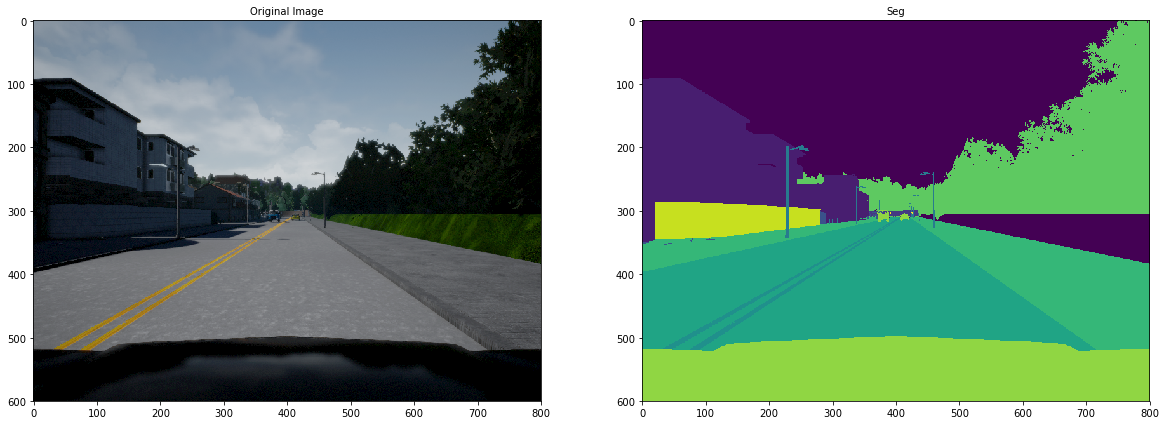

In [4]:
img = mpimg.imread('Train/CameraRGB/0.png')
img2 = mpimg.imread('Train/CameraSeg/0.png')
DisplayImage(img, img2, 'Original Image', 'Seg')

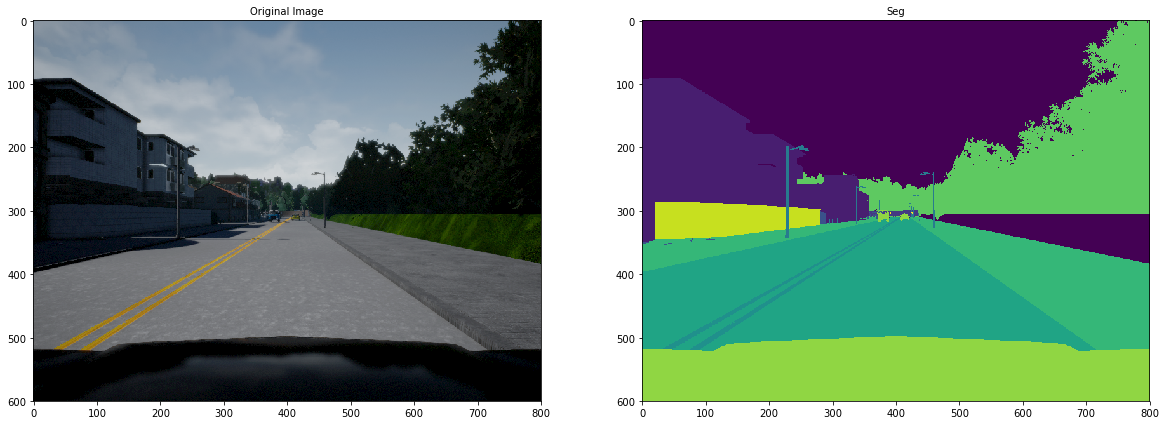

In [5]:
cvimg = cv2.imread('Train/CameraRGB/0.png')
cvimg2 = cv2.imread('Train/CameraSeg/0.png')
DisplayImage(cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB), cv2.cvtColor(cvimg2, cv2.COLOR_BGR2RGB), 'Original Image', 'Seg')

In [6]:
print(img2.shape)
x = 400
y = 799
print(img2[x, y, 0]*256, img2[x, y, 1]*256, img2[x, y, 2]*256)

(600, 800, 3)
8.03137302399 0.0 0.0


In [7]:
img3 = mpimg.imread('../segnet/SegNet-Tutorial/CamVid/trainannot/0001TP_006690.png')

In [8]:
print(img3.shape)
print(img3[10, 10])
print(img3[10, 10]*256)
print(img3[300, 300])
print(img3[300, 300]*256)

(360, 480)
0.00392157
1.003921628
0.0117647
3.01176476479


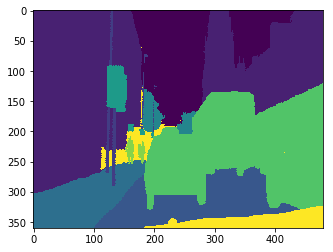

In [9]:
plt.imshow(img3)

(360, 480, 3)


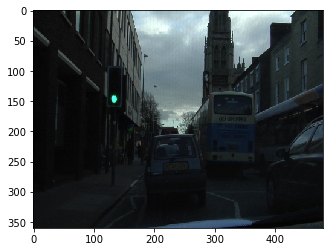

In [10]:
testimg = mpimg.imread('../segnet/SegNet-Tutorial/CamVid/train/0001TP_006690.png')
plt.imshow(testimg)
print (testimg.shape)

In [11]:
height = 600
width = 800
classes = 13

def normalized(rgb):
    if len(rgb.shape) != 3:
        raise RuntimeError('normalized: input data is not 3 dimensional data')

    if rgb.shape[2] != 3:
        raise RuntimeError('normalized: input data is not in RGB color')
        
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3), np.float32)
    norm[:,:,0]=cv2.equalizeHist(rgb[:,:,0])
    norm[:,:,1]=cv2.equalizeHist(rgb[:,:,1])
    norm[:,:,2]=cv2.equalizeHist(rgb[:,:,2])

    return norm

def one_hot_encode(labels):
    if len(labels.shape) != 2:
        raise RuntimeError('one hot encoding: input data is not 2 dimensional data')
        
    x = np.zeros([labels.shape[0], labels.shape[1], classes])
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            x[i,j,int(labels[i][j])]=1
    return x

In [12]:
print(cvimg2.dtype)
encoded = one_hot_encode(cvimg2[:,:,2])
#print(encoded.shape)
#print(img3.shape)
#print(cvimg2[:,:,2].shape)
#encoded2 = one_hot_encode(cvimg2[:,:,2])

#test_a = 350
#test_b = 350
#print(img3[test_a, test_b])
#print("----")
#for i in range(encoded.shape[2]):
#    print (encoded[test_a, test_b, i])

uint8


(600, 800, 3)
64 85.0


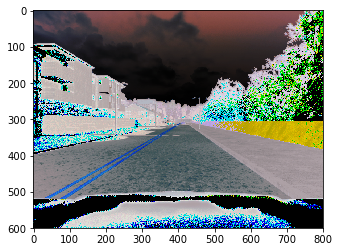

In [13]:
cvimg_nor = normalized(cvimg)
plt.imshow(cv2.cvtColor(cvimg_nor, cv2.COLOR_BGR2RGB))
print (cvimg_nor.shape)
print (cvimg[199, 199, 0] , cvimg_nor[199, 199, 0])


1.003921628


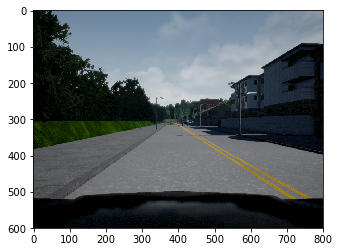

In [14]:
x = 100
y = 300
print(img3[x, y]*256)

image_flipped = np.fliplr(cvimg)
plt.imshow(cv2.cvtColor(image_flipped, cv2.COLOR_BGR2RGB))

https://github.com/imlab-uiip/keras-segnet
https://github.com/preddy5/segnet/blob/master/Segnet.ipynb

https://github.com/0bserver07/Keras-SegNet-Basic

In [16]:
def get_encoding_layers(kernel = (3, 3), pad = 1, pool_size = 2):
    return [
        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(64, kernel),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(128, kernel),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(256, kernel),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(pool_size, pool_size)),

        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(512, kernel),
        BatchNormalization(),
        Activation('relu'),
    ]

def get_decoding_layers(kernel = (3, 3), pad = 1, pool_size = 2):
    return[
        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(512, kernel),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(256, kernel),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(128, kernel),
        BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        ZeroPadding2D(padding=(pad,pad)),
        Conv2D(64, kernel),
        BatchNormalization(),
    ]

segnet_basic = Sequential()
segnet_basic.add(Layer(input_shape=(height, width, 3)))

segnet_basic.encoding_layers = get_encoding_layers()
for l in segnet_basic.encoding_layers:
    segnet_basic.add(l)

segnet_basic.decoding_layers = get_decoding_layers()
for l in segnet_basic.decoding_layers:
    segnet_basic.add(l)

segnet_basic.add(Conv2D(classes, (1, 1)))

segnet_basic.add(Reshape((height*width, classes), input_shape=(height, width, classes)))
segnet_basic.add(Permute((2, 1)))
segnet_basic.add(Activation('softmax'))

#segnet_basic.compile(loss='mse', optimizer='adam')

In [21]:
#segnet_basic.summary()
segnet_basic.compile(loss="sparse_categorical_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [22]:
#segnet_basic.get_weights()
from keras.models import model_from_json

json_string = segnet_basic.to_json()

with open("model.json", "w") as json_file:
    json_file.write(json_string)

json_file2 = open('model.json', 'r')
loaded_model_json = json_file2.read()
json_file2.close()

   
model = model_from_json(loaded_model_json)
#model.summary()

In [23]:
# There are 1000 images. Each one flip once, that product 2000 image.
samples = [i for i in range(2000)]
shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.3)
validation_samples, test_samples = train_test_split(validation_samples, test_size=0.3)

In [24]:
def prep_data(samples):
    images = []
    labels = []
    
    shuffle(samples)
    for sample in samples:
        flip = False
        filenum = sample
        if filenum > 1000:
            flip = True
            filenum = filenum - 1000

        filenum = str(filenum)
        img = cv2.imread ('Train/CameraRGB/' + filenum + '.png')
        label = cv2.imread('Train/CameraSeg/' + filenum + '.png')

        if flip:
            img = np.fliplr(img)
            label = np.fliplr(label)
                    
        images.append(normalized(img))
        labels.append(one_hot_encode(label[:,:,2]))
        print('.',end='')

    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data(train_samples)
train_label = np.reshape(train_label,(len(train_samples),height*width,classes))

........................................................................................................................................................

MemoryError: 

In [19]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            labels = []
            for batch_sample in batch_samples:
                flip = False
                filenum = batch_sample
                if batch_sample > 1000:
                    flip = True
                    filenum = filenum - 1000
                filenum = str(filenum)
                img = cv2.imread ('Train/CameraRGB/' + filenum + '.png')
                label = cv2.imread('Train/CameraSeg/' + filenum + '.png')
                
                if flip:
                    img = np.fliplr(img)
                    label = np.fliplr(label)
                    
                images.append(normalized(img))
                
                label = one_hot_encode(label[:,:,2])
                label = np.reshape(label, (1, height*width ,classes))
                labels.append(label)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(labels)
            yield sklearn.utils.shuffle(X_train, y_train)
            
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
test_generator = generator(test_samples, batch_size=32)

In [20]:
segnet_basic.fit_generator(train_generator, steps_per_epoch= len(train_samples),
                    validation_data=validation_generator, validation_steps=len(validation_samples), epochs=1)

Epoch 1/1


ValueError: Error when checking target: expected activation_9 to have 3 dimensions, but got array with shape (32, 1, 480000, 13)

In [ ]:
scores = segnet_basic.evaluate_generator(test_generator, len(test_samples))
print("Accuracy = ", scores)

In [ ]:
import h5py

segnet_basic.save('model.h5')

